<a href="https://colab.research.google.com/github/janmlew/TensorFlow/blob/master/TensorFlow_C3W2_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 2: Diving deeper into the BBC News archive
Welcome! In this assignment you will be revisiting the [BBC News Classification Dataset](https://www.kaggle.com/c/learn-ai-bbc/overview), which contains 2225 examples of news articles with their respective labels.

This time you will not only work with the tokenization process but you will also create a classifier using specialized layers for text data such as Embedding and GlobalAveragePooling1D.

Let's get started!

In [ ]:
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

You probably remember structure of the csv that contains the data from last week, but in case you need a reminder run the next cell:

In [ ]:
!wget https://raw.githubusercontent.com/janmlew/TensorFlow/master/bbc-text.csv

--2023-10-13 14:32:42--  https://raw.githubusercontent.com/janmlew/TensorFlow/master/bbc-text.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/plain]
Saving to: ‘bbc-text.csv’

bbc-text.csv        100%[===================>]   4.82M  --.-KB/s    in 0.08s   

2023-10-13 14:32:43 (59.5 MB/s) - ‘bbc-text.csv’ saved [5057493/5057493]



In [ ]:
with open("./bbc-text.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

category,text

Each data point looks like this:

tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially

As you can see, each data point is composed of the category of the news article followed by a comma and then the actual text of the article.

# Defining useful global variables
Next, you will define some global variables that will be used in the unit tests after your solutions. **Please do not use these in the function body of the graded functions.**

* NUM_WORDS: The maximum number of words to keep, based on word frequency. Defaults to 1000.
* EMBEDDING_DIM: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 16.
* MAXLEN: Maximum length of all sequences. Defaults to 120.
* PADDING: Padding strategy (pad either before or after each sequence.). Defaults to 'post'.
* OOV_TOKEN: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to "<<OOV>OOV>".
* TRAINING_SPLIT: Proportion of data used for training. Defaults to 0.8

**For now leave them unchanged but after submitting your assignment for grading you are encouraged to come back here and play with these parameters to see the impact they have in the classification process.**

In [ ]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

# Loading and pre-processing the data
Now you should code the functions to remove stopwords from text and to load the data from a csv file.

Since you already coded these functions for the previous week, these are provided for you.

In [ ]:
def remove_stopwords(sentence):
    """
    Removes a list of stopwords

    Args:
        sentence (string): sentence to remove the stopwords from

    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence


def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file

    Args:
        filename (string): path to the CSV file

    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, labels

In [ ]:
# Test the functions
sentences, labels = parse_data_from_file("./bbc-text.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 2225 sentences in the dataset.

First sentence has 436 words (after removing stopwords).

There are 2225 labels in the dataset.

The first 5 labels are ['tech', 'business', 'sport', 'sport', 'entertainment']


***Expected Output**:*

> There are 2225 sentences in the dataset.  
First sentence has 436 words (after removing stopwords).  
There are 2225 labels in the dataset.  
The first 5 labels are ['tech', 'business', 'sport', 'sport', 'entertainment']
# Training - Validation Split
Now you will code the train_val_split() function. Given the training split size, this function will split the full lists of sentences and labels into training and validation sentences and labels.

**IMPORTANT NOTE: For all graded functions in this assignment, please do not use the global variables (e.g. TRAINING_SPLIT) in your solution. Instead, you should use the function parameters defined in the function header (e.g. training_split).**

In [ ]:
# GRADED FUNCTIONS: train_val_split
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets

    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set

    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """

    ### START CODE HERE

    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences)*training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[0:train_size]
    train_labels = labels[0:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    ### END CODE HERE

    return train_sentences, validation_sentences, train_labels, validation_labels

In [ ]:
# Test your function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 1780 sentences for training.

There are 1780 labels for training.

There are 445 sentences for validation.

There are 445 labels for validation.


***Expected Output**:*

> There are 1780 sentences for training.  
There are 1780 labels for training.  
There are 445 sentences for validation.  
There are 445 labels for validation.
# Tokenization - Sequences and padding
Now that you have sets for training and validation it is time for you to begin the tokenization process.

Begin by completing the fit_tokenizer function below. This function should return a [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) that has been fitted to the training sentences.

In [ ]:
# GRADED FUNCTION: fit_tokenizer
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences

    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token

    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """

    ### START CODE HERE

    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)

    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)

    ### END CODE HERE

    return tokenizer

In [ ]:
# Test your function
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 27285 words

<OOV> token included in vocabulary


***Expected Output**:*

> Vocabulary contains 27285 words  
<<OOV>OOV> token included in vocabulary

Now that the tokenizer has been fitted to the training data, you need a function that will convert each text data point into its padded sequence representation, for this complete the seq_and_pad function below:

In [ ]:
# GRADED FUNCTION: seq_and_pad
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length

    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence

    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """
    ### START CODE HERE

    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)

    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)

    ### END CODE HERE

    return padded_sequences

In [ ]:
# Test your function
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (1780, 120)

Padded validation sequences have shape: (445, 120)


***Expected Output**:*

> Padded training sequences have shape: (1780, 120)  
Padded validation sequences have shape: (445, 120)

Finally you need to tokenize the labels. For this complete the tokenize_labels function below.

A couple of things to note:

* You should fit the tokenizer to all the labels to avoid the case of a particular label not being present in the validation set. Since you are dealing with labels there should never be an OOV label.
* In the previous function you used the pad_sequences function which returns numpy arrays. Here you will not be using it since you don't need to pad the labels so you need to make the conversion to numpy arrays yourself.
* The argument split_labels refers to the labels of a particular split (train or validation). This is because the function should work independently of the split being used.
* Using Keras' Tokenizer yields values that start at 1 rather than at 0. This will present a problem when training since Keras usually expects the labels to start at 0. To work around this issue you could use an extra neuron in the last layer of your model. However this approach is rather hacky and not very clear. Instead you will substract 1 from every value of the labels that the function returns. Remember that when using numpy arrays you can simply do something like np.array - 1 to accomplish this since numpy allows for vectorized operations.

In [ ]:
# GRADED FUNCTION: tokenize_labels
def tokenize_labels(all_labels, split_labels):
    """
    Tokenizes the labels

    Args:
        all_labels (list of string): labels to generate the word-index from
        split_labels (list of string): labels to tokenize

    Returns:
        label_seq_np (array of int): tokenized labels
    """
    ### START CODE HERE

    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer(num_words=len(all_labels))

    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)

    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)

    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    label_seq_np = np.array(label_seq) - 1

    ### END CODE HERE

    return label_seq_np

In [ ]:
# Test your function
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[3]
 [1]
 [0]
 [0]
 [4]]

First 5 labels of the validation set should look like this:
[[4]
 [3]
 [2]
 [0]
 [0]]

Tokenized labels of the training set have shape: (1780, 1)

Tokenized labels of the validation set have shape: (445, 1)



***Expected Output**:*

> First 5 labels of the training set should look like this:  
[[3]  
 [1]  
 [0]  
 [0]  
 [4]]
>
> First 5 labels of the validation set should look like this:  
[[4]  
 [3]  
 [2]  
 [0]  
 [0]]
>
> Tokenized labels of the training set have shape: (1780, 1)
>
> Tokenized labels of the validation set have shape: (445, 1)
# Selecting the model for text classification
Now that the data is ready to be fed a Neural Network it is time for you to define the model that will classify each text as being part of a certain category.

For this complete the create_model below.

A couple of things to keep in mind:

* Notice that this function has three parameters, all of which are meant to be passed to an [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer, which is what you will probably use as a first layer for your model.
* The last layer should be a Dense layer with 5 units (since there are 5 categories) with a softmax activation.
* You should also compile your model using an appropiate loss function and optimizer.
* You can use any architecture you want but keep in mind that this problem doesn't need many layers to be solved successfully. You don't need any layers beside Embedding, [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) and Dense layers but feel free to try out different architectures.
* **To pass this graded function your model should reach at least a 95% training accuracy and a 90% validation accuracy in under 30 epochs.**

In [ ]:
# GRADED FUNCTION: create_model
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model

    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text classifier model
    """

    tf.random.set_seed(123)

    ### START CODE HERE

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(25, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    ### END CODE HERE

    return model

In [ ]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
56/56 [==============================] - 12s 117ms/step - loss: 1.5891 - accuracy: 0.2809 - val_loss: 1.5491 - val_accuracy: 0.3573
Epoch 2/30
56/56 [==============================] - 4s 71ms/step - loss: 1.3433 - accuracy: 0.5382 - val_loss: 1.1792 - val_accuracy: 0.6045
Epoch 3/30
56/56 [==============================] - 3s 57ms/step - loss: 0.8309 - accuracy: 0.8051 - val_loss: 0.7531 - val_accuracy: 0.7955
Epoch 4/30
56/56 [==============================] - 2s 32ms/step - loss: 0.4281 - accuracy: 0.9348 - val_loss: 0.4961 - val_accuracy: 0.8607
Epoch 5/30
56/56 [==============================] - 1s 21ms/step - loss: 0.2082 - accuracy: 0.9697 - val_loss: 0.3379 - val_accuracy: 0.9056
Epoch 6/30
56/56 [==============================] - 2s 30ms/step - loss: 0.1039 - accuracy: 0.9899 - val_loss: 0.2924 - val_accuracy: 0.9079
Epoch 7/30
56/56 [==============================] - 1s 9ms/step - loss: 0.0505 - accuracy: 0.9978 - val_loss: 0.2644 - val_accuracy: 0.9079
Epoch 8/30
5

Once training has finished you can run the following cell to check the training and validation accuracy achieved at the end of each epoch.

**Remember that to pass this assignment your model should achieve a training accuracy of at least 95% and a validation accuracy of at least 90%. If your model didn't achieve these thresholds, try training again with a different model architecture.**

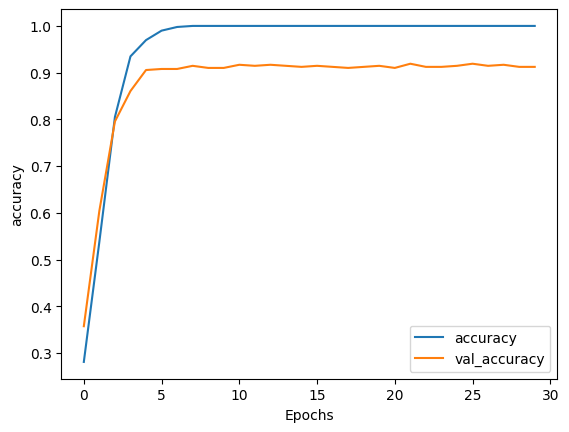

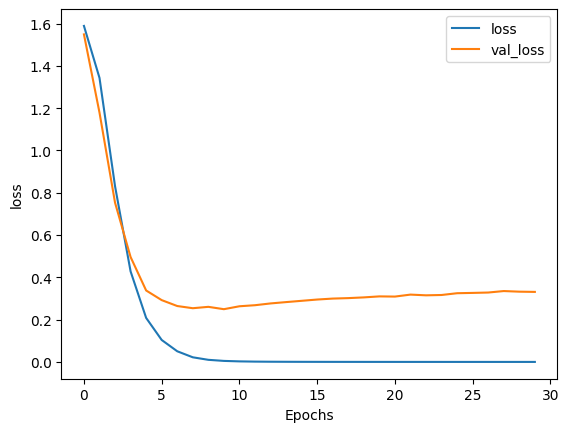

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**If your model passes the previously mentioned thresholds be sure to save your notebook and submit for grading before jumping onto the next section.**

# Optional Exercise - Visualizing 3D Vectors
As you saw on the lecture you can visualize the vectors associated with each word in the training set in a 3D space.

For this run the following cells and visit [Tensorflow's Embedding Projector](https://projector.tensorflow.org/).

In [ ]:
# Reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Save the embedding layer
e = model.layers[0]

# Save the weights of the embedding layer
weights = e.get_weights()[0]
print(f"Weights of embedding layer have shape: {weights.shape}")

Weights of embedding layer have shape: (1000, 16)


***Expected Output**:*

> Weights of embedding layer have shape: (1000, 16)
>
> The above is true if global variables are not modified.
Notice that this shape will always be (NUM_WORDS, EMBEDDING_DIM).

Now run the following cell to generate the vecs.tsv and meta.tsv files that you will upload to the embedding projector.

In [ ]:
# Generate files for embedding visualization
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, NUM_WORDS):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

Before downloading these files be sure to having already submitted your assignment.

By running the previous cell, these files are placed within your filesystem. To download them, click on the Jupyter logo on the upper-left side of the screen. This will take you to the Jupyter filesystem and there you can download the files by selecting them and clicking on the Download button.

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of classifying text and also learned about embeddings and tokenization along the way!

**Keep it up!**

In [21]:
# Import files utilities in Colab
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>